**IMPORT LIBRARIES**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # For a nice progress bar!
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

**ULTIS**


In [5]:
def concat_csv():
    # Take the path of all the data
    # Read data
    df = pd.read_csv('/kaggle/input/datasolar/Data_Solar_cut.csv',header=0)
    df.set_index('DATE (MM/DD/YYYY)', inplace=True)
    df = df.fillna(method = 'ffill')
    return df

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr(method='spearman')  # Calculate Spearman correlation
    num_columns = len(corr_matrix.columns)
    for i in range(num_columns):
        if i != 0:
            if abs(corr_matrix.iloc[i,25 ]) < threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr
def get_loader(dataset,batch_size=16,shuffle=False):

    loader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=shuffle)
    return loader

def save_checkpoint(state, filename="checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
def ordered_train_val_test_split(df, val_size, test_size):
    # Calculate the splitting indices
    val_index = int(len(df) * (1 - val_size - test_size))
    test_index = int(len(df) * (1 - test_size))

    # Split the DataFrame
    train_data = df.iloc[:val_index]
    val_data = df.iloc[val_index:test_index]
    test_data = df.iloc[test_index:]

    return train_data, val_data, test_data


In [6]:
df = concat_csv()
print(df.info())  # Kiểm tra kiểu dữ liệu

/tmp/ipykernel_35/1664809209.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'ffill')


<class 'pandas.core.frame.DataFrame'>
Index: 1742341 entries, 2015-01-01 00:00:00 to 2018-04-24 23:00:00
Data columns (total 26 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   Zenith Angle [degrees]                  float64
 1   Azimuth Angle [degrees]                 float64
 2   Airmass                                 float64
 3   Tower Dry Bulb Temp [deg C]             float64
 4   Tower Wet Bulb Temp [deg C]             float64
 5   Tower Dew Point Temp [deg C]            float64
 6   Tower Wind Chill Temp [deg C]           float64
 7   Tower RH [%]                            float64
 8   Total Cloud Cover [%]                   int64  
 9   Opaque Cloud Cover [%]                  int64  
 10  Avg Wind Speed @ 19ft [m/s]             float64
 11  Peak Wind Speed @ 19ft [m/s]            float64
 12  Avg Wind Direction @ 19ft [deg from N]  float64
 13  Vertical Wind Shear [1/s]               float64
 14  Station P

**MODEL**

In [7]:

device = "cuda" if torch.cuda.is_available() else "cpu"

class BRNN(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2, seq_length=12, dropout=0.3):
        super(BRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Thêm dropout vào LSTM
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout)  # Dropout trước fully connected
        self.fc = nn.Linear(hidden_size * seq_length * 2, seq_length)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)  # Áp dụng dropout
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

# Test thử
model = BRNN()
x = torch.rand((16, 12, 5))
print(model(x).shape)  # => torch.Size([16, 12])


torch.Size([16, 12])


**DATASET**

In [8]:
class Irradiation_Dataset(Dataset):
    def __init__(self,data,target,trainop1=True):
        self.data = data # shape [num_samples,num_feature]
        self.target = target # shape [num_samples,1]
        self.trainop1 = trainop1
    def __len__(self):
        if self.trainop1:
            return self.data.shape[0]//24-1
        else:
            return self.data.shape[0]//24

    def __getitem__(self,index):
        if self.trainop1:
            seq_length =  24
            features_start_idx = index*seq_length
            features_end_idx = (index+1)*seq_length

            targets_start_idx = (index+1)*seq_length
            targets_end_idx = targets_start_idx+24
            features = self.data[features_start_idx:features_end_idx, :]
            targets = self.target[targets_start_idx:targets_end_idx]

            return torch.tensor(features),torch.tensor(targets)
        else:
            seq_length =  24
            features_start_idx = index*seq_length
            features_end_idx = (index+1)*seq_length

            targets_start_idx = index * seq_length
            targets_end_idx = (index+1)*seq_length
            features = self.data[features_start_idx:features_end_idx, :]
            targets = self.target[targets_start_idx:targets_end_idx]



        return torch.tensor(features),torch.tensor(targets)

In [9]:
df = df.iloc[:, [0, 2, 3, 7, 9, 12, 23, 25]]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1742341 entries, 2015-01-01 00:00:00 to 2018-04-24 23:00:00
Data columns (total 8 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   Zenith Angle [degrees]                  float64
 1   Airmass                                 float64
 2   Tower Dry Bulb Temp [deg C]             float64
 3   Tower RH [%]                            float64
 4   Opaque Cloud Cover [%]                  int64  
 5   Avg Wind Direction @ 19ft [deg from N]  float64
 6   Global Extraterrestrial (calc) [W/m^2]  float64
 7   GHI Mean                                float64
dtypes: float64(7), int64(1)
memory usage: 119.6+ MB
None


In [10]:
target_column = 'GHI Mean'
trainop1 = True

X = df
Y = df[target_column]
Y = pd.DataFrame({target_column: Y})

X_train, X_val, X_test = ordered_train_val_test_split(X,0.1,0.1)
Y_train, Y_val, Y_test = ordered_train_val_test_split(Y,0.1,0.1)

if not trainop1:
    X_train = X_train.drop(target_column,axis=1)
    X_val = X_val.drop(target_column,axis=1)
    X_test = X_test.drop(target_column,axis=1)

In [11]:
X_scaler = StandardScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns).values
X_val = pd.DataFrame(X_scaler.transform(X_val), columns=X_val.columns).values
X_test = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns).values


Y_scaler = StandardScaler()
Y_train = pd.DataFrame(Y_scaler.fit_transform(Y_train), columns=Y_train.columns).values
Y_val = pd.DataFrame(Y_scaler.transform(Y_val), columns=Y_val.columns).values
Y_test = pd.DataFrame(Y_scaler.transform(Y_test), columns=Y_test.columns).values

# print(Y_test)

In [12]:
print("The shape of the original data:",df.shape)
print("The shape of the train data:",X_train.shape)
print("The shape of the train target:",Y_train.shape)
print("The shape of the val data:",X_val.shape)
print("The shape of the val target:",Y_val.shape)
print("The shape of the test data:",X_test.shape)
print("The shape of the test target:",Y_test.shape)

train_data = Irradiation_Dataset(X_train,Y_train,trainop1=trainop1)
val_data = Irradiation_Dataset(X_val,Y_val,trainop1=trainop1)
test_data = Irradiation_Dataset(X_test,Y_test,trainop1=trainop1)

print(len(train_data))
print(len(val_data))
print(len(test_data))

train_data_loader = get_loader(train_data)
val_data_loader = get_loader(val_data)
test_data_loader = get_loader(test_data)


The shape of the original data: (1742341, 8)
The shape of the train data: (1393872, 8)
The shape of the train target: (1393872, 1)
The shape of the val data: (174234, 8)
The shape of the val target: (174234, 1)
The shape of the test data: (174235, 8)
The shape of the test target: (174235, 1)
58077
7258
7258


**TRAIN**

In [13]:
#HYPERPARAMETERS
input_size = 8
hidden_size = 64
num_layers = 2
sequence_length = 24
learning_rate = 0.01
batch_size = 16
num_epochs = 300
min_valid_loss = np.inf

In [14]:
# MODEL
model = BRNN(input_size=input_size,
             hidden_size=hidden_size,
             num_layers=num_layers,
             seq_length=sequence_length).to(device=device)

# randn_tensor = torch.randn((16,12,10))
# x = model(randn_tensor)
# x.shape

In [15]:
#LOSS AND OPTIMIZER
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.LinearLR(optimizer=optimizer,
                                        start_factor=1.0,
                                        end_factor=0.01)

In [16]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        """
        patience: số epoch chờ đợi sau khi validation loss không giảm
        min_delta: mức giảm tối thiểu của validation loss để coi là cải thiện
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # reset counter nếu cải thiện
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [17]:
#TRAIN THE MODEL
for epoch in range(num_epochs):
    print("Epoch: ",epoch)
    train_loss = 0
    model.train()
    for batch_idx,(data,target) in enumerate(tqdm(train_data_loader)):
        data = data.to(device=device,dtype=torch.float)
        target = target.to(device=device,dtype=torch.float).squeeze(2)

        scores = model(data)
        loss = criterion(scores,target)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        train_loss += loss.item()
    scheduler.step()
    print("Train Loss:",train_loss / len(train_data_loader))
    valid_loss = 0

    model.eval()
    with torch.no_grad():
        total_scores_val = None
        total_target_val = None
        for batch_idx_val,(data_val,target_val) in enumerate(tqdm(val_data_loader)):
            data_val = data_val.to(device=device,dtype=torch.float)
            target_val = target_val.to(device=device,dtype=torch.float).squeeze(2)

            scores_val = model(data_val)
            loss_val = criterion(scores_val,target_val)

            valid_loss += loss_val.item()
    print("Validation Loss:", valid_loss/len(val_data_loader))

    if min_valid_loss > valid_loss/len(val_data_loader):
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{(valid_loss/len(val_data_loader)):.6f} \t Saving The Model')
        min_valid_loss = valid_loss/len(val_data_loader)
        # Saving State Dict
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint)
        torch.save(model, "model_predict_.pth.tar")


Epoch:  0


100%|██████████| 3630/3630 [00:15<00:00, 239.14it/s]


Train Loss: 0.12682725933448413


100%|██████████| 454/454 [00:00<00:00, 953.17it/s]


Validation Loss: 0.08727458801242577
Validation Loss Decreased(inf--->0.087275 	 Saving The Model
=> Saving checkpoint
Epoch:  1


100%|██████████| 3630/3630 [00:14<00:00, 252.40it/s]


Train Loss: 0.09729903531025072


100%|██████████| 454/454 [00:00<00:00, 909.92it/s]


Validation Loss: 0.06011096826210384
Validation Loss Decreased(0.087275--->0.060111 	 Saving The Model
=> Saving checkpoint
Epoch:  2


100%|██████████| 3630/3630 [00:14<00:00, 253.37it/s]


Train Loss: 0.09091389202113526


100%|██████████| 454/454 [00:00<00:00, 892.05it/s]


Validation Loss: 0.051161733221554755
Validation Loss Decreased(0.060111--->0.051162 	 Saving The Model
=> Saving checkpoint
Epoch:  3


100%|██████████| 3630/3630 [00:14<00:00, 247.94it/s]


Train Loss: 0.08691102508182917


100%|██████████| 454/454 [00:00<00:00, 908.53it/s]


Validation Loss: 0.04586350971055658
Validation Loss Decreased(0.051162--->0.045864 	 Saving The Model
=> Saving checkpoint
Epoch:  4


100%|██████████| 3630/3630 [00:14<00:00, 249.96it/s]


Train Loss: 0.0826890787366616


100%|██████████| 454/454 [00:00<00:00, 937.34it/s]


Validation Loss: 0.04216020596930978
Validation Loss Decreased(0.045864--->0.042160 	 Saving The Model
=> Saving checkpoint
Epoch:  5


100%|██████████| 3630/3630 [00:14<00:00, 245.89it/s]


Train Loss: 0.08154701726138623


100%|██████████| 454/454 [00:00<00:00, 887.07it/s]


Validation Loss: 0.03590840293666304
Validation Loss Decreased(0.042160--->0.035908 	 Saving The Model
=> Saving checkpoint
Epoch:  6


100%|██████████| 3630/3630 [00:14<00:00, 246.65it/s]


Train Loss: 0.08056815131913778


100%|██████████| 454/454 [00:00<00:00, 928.24it/s]


Validation Loss: 0.03557266557611866
Validation Loss Decreased(0.035908--->0.035573 	 Saving The Model
=> Saving checkpoint
Epoch:  7


100%|██████████| 3630/3630 [00:15<00:00, 239.24it/s]


Train Loss: 0.08018082400861506


100%|██████████| 454/454 [00:00<00:00, 925.38it/s]


Validation Loss: 0.035361550615153337
Validation Loss Decreased(0.035573--->0.035362 	 Saving The Model
=> Saving checkpoint
Epoch:  8


100%|██████████| 3630/3630 [00:14<00:00, 248.15it/s]


Train Loss: 0.07998567647973336


100%|██████████| 454/454 [00:00<00:00, 948.02it/s]


Validation Loss: 0.03528194465730039
Validation Loss Decreased(0.035362--->0.035282 	 Saving The Model
=> Saving checkpoint
Epoch:  9


100%|██████████| 3630/3630 [00:14<00:00, 246.30it/s]


Train Loss: 0.07938310710545539


100%|██████████| 454/454 [00:00<00:00, 930.55it/s]


Validation Loss: 0.035171034167922194
Validation Loss Decreased(0.035282--->0.035171 	 Saving The Model
=> Saving checkpoint
Epoch:  10


100%|██████████| 3630/3630 [00:14<00:00, 247.68it/s]


Train Loss: 0.07933825969664937


100%|██████████| 454/454 [00:00<00:00, 953.90it/s]


Validation Loss: 0.0350880168652099
Validation Loss Decreased(0.035171--->0.035088 	 Saving The Model
=> Saving checkpoint
Epoch:  11


100%|██████████| 3630/3630 [00:15<00:00, 241.03it/s]


Train Loss: 0.07938291688292376


100%|██████████| 454/454 [00:00<00:00, 949.23it/s]


Validation Loss: 0.0349923681784468
Validation Loss Decreased(0.035088--->0.034992 	 Saving The Model
=> Saving checkpoint
Epoch:  12


100%|██████████| 3630/3630 [00:14<00:00, 247.54it/s]


Train Loss: 0.07910562249959815


100%|██████████| 454/454 [00:00<00:00, 941.40it/s]


Validation Loss: 0.034982053633723004
Validation Loss Decreased(0.034992--->0.034982 	 Saving The Model
=> Saving checkpoint
Epoch:  13


100%|██████████| 3630/3630 [00:14<00:00, 244.66it/s]


Train Loss: 0.0789789379431886


100%|██████████| 454/454 [00:00<00:00, 942.27it/s]


Validation Loss: 0.034966775358892775
Validation Loss Decreased(0.034982--->0.034967 	 Saving The Model
=> Saving checkpoint
Epoch:  14


100%|██████████| 3630/3630 [00:14<00:00, 246.16it/s]


Train Loss: 0.07862320659627955


100%|██████████| 454/454 [00:00<00:00, 922.93it/s]


Validation Loss: 0.03484377953197553
Validation Loss Decreased(0.034967--->0.034844 	 Saving The Model
=> Saving checkpoint
Epoch:  15


100%|██████████| 3630/3630 [00:14<00:00, 245.41it/s]


Train Loss: 0.0785128342978462


100%|██████████| 454/454 [00:00<00:00, 951.04it/s]


Validation Loss: 0.0347408891437242
Validation Loss Decreased(0.034844--->0.034741 	 Saving The Model
=> Saving checkpoint
Epoch:  16


100%|██████████| 3630/3630 [00:14<00:00, 245.81it/s]


Train Loss: 0.0786238529880646


100%|██████████| 454/454 [00:00<00:00, 943.36it/s]


Validation Loss: 0.03476089597311149
Epoch:  17


100%|██████████| 3630/3630 [00:14<00:00, 243.51it/s]


Train Loss: 0.0785336384365974


100%|██████████| 454/454 [00:00<00:00, 927.94it/s]


Validation Loss: 0.0346741093290574
Validation Loss Decreased(0.034741--->0.034674 	 Saving The Model
=> Saving checkpoint
Epoch:  18


100%|██████████| 3630/3630 [00:14<00:00, 245.61it/s]


Train Loss: 0.07841078649325836


100%|██████████| 454/454 [00:00<00:00, 937.61it/s]


Validation Loss: 0.03465091015848259
Validation Loss Decreased(0.034674--->0.034651 	 Saving The Model
=> Saving checkpoint
Epoch:  19


100%|██████████| 3630/3630 [00:14<00:00, 244.21it/s]


Train Loss: 0.07791034264697504


100%|██████████| 454/454 [00:00<00:00, 937.73it/s]


Validation Loss: 0.034578160697127824
Validation Loss Decreased(0.034651--->0.034578 	 Saving The Model
=> Saving checkpoint
Epoch:  20


100%|██████████| 3630/3630 [00:14<00:00, 243.86it/s]


Train Loss: 0.07790397484518219


100%|██████████| 454/454 [00:00<00:00, 875.25it/s]


Validation Loss: 0.03455016038432333
Validation Loss Decreased(0.034578--->0.034550 	 Saving The Model
=> Saving checkpoint
Epoch:  21


100%|██████████| 3630/3630 [00:15<00:00, 241.55it/s]


Train Loss: 0.0780800201915193


100%|██████████| 454/454 [00:00<00:00, 942.91it/s]


Validation Loss: 0.034568790931810166
Epoch:  22


100%|██████████| 3630/3630 [00:14<00:00, 245.53it/s]


Train Loss: 0.07788168023312021


100%|██████████| 454/454 [00:00<00:00, 932.77it/s]


Validation Loss: 0.0345307207105043
Validation Loss Decreased(0.034550--->0.034531 	 Saving The Model
=> Saving checkpoint
Epoch:  23


100%|██████████| 3630/3630 [00:15<00:00, 239.66it/s]


Train Loss: 0.07777409052603607


100%|██████████| 454/454 [00:00<00:00, 940.64it/s]


Validation Loss: 0.03449798738191598
Validation Loss Decreased(0.034531--->0.034498 	 Saving The Model
=> Saving checkpoint
Epoch:  24


100%|██████████| 3630/3630 [00:14<00:00, 244.15it/s]


Train Loss: 0.07766880462592828


100%|██████████| 454/454 [00:00<00:00, 949.67it/s]


Validation Loss: 0.0345270306492928
Epoch:  25


100%|██████████| 3630/3630 [00:14<00:00, 242.52it/s]


Train Loss: 0.07741032393914442


100%|██████████| 454/454 [00:00<00:00, 940.48it/s]


Validation Loss: 0.034427787594494386
Validation Loss Decreased(0.034498--->0.034428 	 Saving The Model
=> Saving checkpoint
Epoch:  26


100%|██████████| 3630/3630 [00:14<00:00, 244.81it/s]


Train Loss: 0.07762205634406767


100%|██████████| 454/454 [00:00<00:00, 915.62it/s]


Validation Loss: 0.03444652761858868
Epoch:  27


100%|██████████| 3630/3630 [00:15<00:00, 237.59it/s]


Train Loss: 0.07723722849531499


100%|██████████| 454/454 [00:00<00:00, 947.92it/s]


Validation Loss: 0.034363953780484735
Validation Loss Decreased(0.034428--->0.034364 	 Saving The Model
=> Saving checkpoint
Epoch:  28


100%|██████████| 3630/3630 [00:14<00:00, 245.69it/s]


Train Loss: 0.07698284118360431


100%|██████████| 454/454 [00:00<00:00, 937.34it/s]


Validation Loss: 0.034334561165839945
Validation Loss Decreased(0.034364--->0.034335 	 Saving The Model
=> Saving checkpoint
Epoch:  29


100%|██████████| 3630/3630 [00:15<00:00, 239.95it/s]


Train Loss: 0.07706247718319888


100%|██████████| 454/454 [00:00<00:00, 910.00it/s]


Validation Loss: 0.034315660329181534
Validation Loss Decreased(0.034335--->0.034316 	 Saving The Model
=> Saving checkpoint
Epoch:  30


100%|██████████| 3630/3630 [00:14<00:00, 243.35it/s]


Train Loss: 0.07707007403870962


100%|██████████| 454/454 [00:00<00:00, 921.29it/s]


Validation Loss: 0.034316279565317194
Epoch:  31


100%|██████████| 3630/3630 [00:14<00:00, 244.94it/s]


Train Loss: 0.07732250010136922


100%|██████████| 454/454 [00:00<00:00, 788.36it/s]


Validation Loss: 0.034309849271212924
Validation Loss Decreased(0.034316--->0.034310 	 Saving The Model
=> Saving checkpoint
Epoch:  32


100%|██████████| 3630/3630 [00:14<00:00, 242.61it/s]


Train Loss: 0.07697256056286558


100%|██████████| 454/454 [00:00<00:00, 945.43it/s]


Validation Loss: 0.034258264912618526
Validation Loss Decreased(0.034310--->0.034258 	 Saving The Model
=> Saving checkpoint
Epoch:  33


100%|██████████| 3630/3630 [00:14<00:00, 246.75it/s]


Train Loss: 0.0768746238133226


100%|██████████| 454/454 [00:00<00:00, 930.96it/s]


Validation Loss: 0.0343806148022353
Epoch:  34


100%|██████████| 3630/3630 [00:14<00:00, 243.17it/s]


Train Loss: 0.07694194433099742


100%|██████████| 454/454 [00:00<00:00, 932.30it/s]


Validation Loss: 0.03427736523712965
Epoch:  35


100%|██████████| 3630/3630 [00:14<00:00, 244.05it/s]


Train Loss: 0.07674838632842129


100%|██████████| 454/454 [00:00<00:00, 930.80it/s]


Validation Loss: 0.034223616983984115
Validation Loss Decreased(0.034258--->0.034224 	 Saving The Model
=> Saving checkpoint
Epoch:  36


100%|██████████| 3630/3630 [00:14<00:00, 242.71it/s]


Train Loss: 0.07641574693159822


100%|██████████| 454/454 [00:00<00:00, 940.90it/s]


Validation Loss: 0.0342200875417005
Validation Loss Decreased(0.034224--->0.034220 	 Saving The Model
=> Saving checkpoint
Epoch:  37


100%|██████████| 3630/3630 [00:14<00:00, 245.90it/s]


Train Loss: 0.0766198182691013


100%|██████████| 454/454 [00:00<00:00, 935.69it/s]


Validation Loss: 0.0341566388058124
Validation Loss Decreased(0.034220--->0.034157 	 Saving The Model
=> Saving checkpoint
Epoch:  38


100%|██████████| 3630/3630 [00:14<00:00, 246.18it/s]


Train Loss: 0.0764178817842724


100%|██████████| 454/454 [00:00<00:00, 947.67it/s]


Validation Loss: 0.0341802694194789
Epoch:  39


100%|██████████| 3630/3630 [00:14<00:00, 252.29it/s]


Train Loss: 0.07654915416269908


100%|██████████| 454/454 [00:00<00:00, 964.21it/s]


Validation Loss: 0.03421986844835329
Epoch:  40


100%|██████████| 3630/3630 [00:14<00:00, 247.84it/s]


Train Loss: 0.07596605768709151


100%|██████████| 454/454 [00:00<00:00, 935.92it/s]


Validation Loss: 0.03407908494115957
Validation Loss Decreased(0.034157--->0.034079 	 Saving The Model
=> Saving checkpoint
Epoch:  41


100%|██████████| 3630/3630 [00:14<00:00, 251.41it/s]


Train Loss: 0.07633172276349416


100%|██████████| 454/454 [00:00<00:00, 955.66it/s]


Validation Loss: 0.03415631871430458
Epoch:  42


100%|██████████| 3630/3630 [00:14<00:00, 243.99it/s]


Train Loss: 0.07593256343281495


100%|██████████| 454/454 [00:00<00:00, 933.56it/s]


Validation Loss: 0.03408995777044365
Epoch:  43


100%|██████████| 3630/3630 [00:14<00:00, 249.77it/s]


Train Loss: 0.07613137464420504


100%|██████████| 454/454 [00:00<00:00, 937.32it/s]


Validation Loss: 0.03401751553629096
Validation Loss Decreased(0.034079--->0.034018 	 Saving The Model
=> Saving checkpoint
Epoch:  44


100%|██████████| 3630/3630 [00:14<00:00, 244.78it/s]


Train Loss: 0.07578701538477316


100%|██████████| 454/454 [00:00<00:00, 952.22it/s]


Validation Loss: 0.034145418153681655
Epoch:  45


100%|██████████| 3630/3630 [00:14<00:00, 244.73it/s]


Train Loss: 0.07549132511079679


100%|██████████| 454/454 [00:00<00:00, 926.06it/s]


Validation Loss: 0.03419329280220479
Epoch:  46


100%|██████████| 3630/3630 [00:15<00:00, 240.13it/s]


Train Loss: 0.07578456334255959


100%|██████████| 454/454 [00:00<00:00, 919.26it/s]


Validation Loss: 0.034107725189930695
Epoch:  47


100%|██████████| 3630/3630 [00:15<00:00, 241.52it/s]


Train Loss: 0.07546574325750059


100%|██████████| 454/454 [00:00<00:00, 847.03it/s]


Validation Loss: 0.03408861307105022
Epoch:  48


100%|██████████| 3630/3630 [00:14<00:00, 247.31it/s]


Train Loss: 0.07553861553023233


100%|██████████| 454/454 [00:00<00:00, 838.22it/s]


Validation Loss: 0.033995063359016295
Validation Loss Decreased(0.034018--->0.033995 	 Saving The Model
=> Saving checkpoint
Epoch:  49


100%|██████████| 3630/3630 [00:14<00:00, 242.59it/s]


Train Loss: 0.07503245969169219


100%|██████████| 454/454 [00:00<00:00, 922.85it/s]


Validation Loss: 0.03401129678648447
Epoch:  50


100%|██████████| 3630/3630 [00:15<00:00, 238.89it/s]


Train Loss: 0.07518266724132257


100%|██████████| 454/454 [00:00<00:00, 937.19it/s]


Validation Loss: 0.034094621261662884
Epoch:  51


100%|██████████| 3630/3630 [00:14<00:00, 245.80it/s]


Train Loss: 0.0750200439610271


100%|██████████| 454/454 [00:00<00:00, 931.19it/s]


Validation Loss: 0.03405015463659457
Epoch:  52


100%|██████████| 3630/3630 [00:14<00:00, 243.59it/s]


Train Loss: 0.07526890203540265


100%|██████████| 454/454 [00:00<00:00, 907.80it/s]


Validation Loss: 0.034106242435361596
Epoch:  53


100%|██████████| 3630/3630 [00:14<00:00, 244.57it/s]


Train Loss: 0.07517072000553941


100%|██████████| 454/454 [00:00<00:00, 951.31it/s]


Validation Loss: 0.03403782042571463
Epoch:  54


100%|██████████| 3630/3630 [00:14<00:00, 244.28it/s]


Train Loss: 0.07491100975804572


100%|██████████| 454/454 [00:00<00:00, 932.32it/s]


Validation Loss: 0.033990558435431764
Validation Loss Decreased(0.033995--->0.033991 	 Saving The Model
=> Saving checkpoint
Epoch:  55


100%|██████████| 3630/3630 [00:14<00:00, 246.38it/s]


Train Loss: 0.0746474707769339


100%|██████████| 454/454 [00:00<00:00, 956.88it/s]


Validation Loss: 0.03408282965997166
Epoch:  56


100%|██████████| 3630/3630 [00:14<00:00, 248.22it/s]


Train Loss: 0.07459964799185119


100%|██████████| 454/454 [00:00<00:00, 877.45it/s]


Validation Loss: 0.034103910728933366
Epoch:  57


100%|██████████| 3630/3630 [00:14<00:00, 247.50it/s]


Train Loss: 0.07461797667774865


100%|██████████| 454/454 [00:00<00:00, 912.21it/s]


Validation Loss: 0.0340165724238604
Epoch:  58


100%|██████████| 3630/3630 [00:14<00:00, 250.26it/s]


Train Loss: 0.07431617234379743


100%|██████████| 454/454 [00:00<00:00, 945.45it/s]


Validation Loss: 0.03405082584596422
Epoch:  59


100%|██████████| 3630/3630 [00:14<00:00, 243.11it/s]


Train Loss: 0.07438303265542134


100%|██████████| 454/454 [00:00<00:00, 960.08it/s]


Validation Loss: 0.03402155598734984
Epoch:  60


100%|██████████| 3630/3630 [00:14<00:00, 248.53it/s]


Train Loss: 0.07419072079832875


100%|██████████| 454/454 [00:00<00:00, 872.63it/s]


Validation Loss: 0.03403778694930409
Epoch:  61


100%|██████████| 3630/3630 [00:14<00:00, 248.39it/s]


Train Loss: 0.0743000377859608


100%|██████████| 454/454 [00:00<00:00, 961.05it/s]


Validation Loss: 0.03407716667917129
Epoch:  62


100%|██████████| 3630/3630 [00:14<00:00, 250.02it/s]


Train Loss: 0.07373158156961752


100%|██████████| 454/454 [00:00<00:00, 942.64it/s]


Validation Loss: 0.03406400437219346
Epoch:  63


100%|██████████| 3630/3630 [00:14<00:00, 250.54it/s]


Train Loss: 0.07406379848846283


100%|██████████| 454/454 [00:00<00:00, 936.32it/s]


Validation Loss: 0.03406029111029697
Epoch:  64


100%|██████████| 3630/3630 [00:14<00:00, 250.89it/s]


Train Loss: 0.07401413387851388


100%|██████████| 454/454 [00:00<00:00, 960.97it/s]


Validation Loss: 0.03409768741727474
Epoch:  65


100%|██████████| 3630/3630 [00:14<00:00, 247.05it/s]


Train Loss: 0.07414843691013447


100%|██████████| 454/454 [00:00<00:00, 933.55it/s]


Validation Loss: 0.03405153713645688
Epoch:  66


100%|██████████| 3630/3630 [00:14<00:00, 249.01it/s]


Train Loss: 0.0739685184037954


100%|██████████| 454/454 [00:00<00:00, 938.24it/s]


Validation Loss: 0.03411626341586363
Epoch:  67


100%|██████████| 3630/3630 [00:14<00:00, 245.53it/s]


Train Loss: 0.07380450775113391


100%|██████████| 454/454 [00:00<00:00, 929.74it/s]


Validation Loss: 0.03416911341012681
Epoch:  68


100%|██████████| 3630/3630 [00:14<00:00, 248.89it/s]


Train Loss: 0.07382318249718574


100%|██████████| 454/454 [00:00<00:00, 951.49it/s]


Validation Loss: 0.034086511784469635
Epoch:  69


100%|██████████| 3630/3630 [00:14<00:00, 245.11it/s]


Train Loss: 0.0735644458295332


100%|██████████| 454/454 [00:00<00:00, 940.12it/s]


Validation Loss: 0.034185054641125034
Epoch:  70


100%|██████████| 3630/3630 [00:14<00:00, 248.78it/s]


Train Loss: 0.07350766078859873


100%|██████████| 454/454 [00:00<00:00, 932.08it/s]


Validation Loss: 0.034062414116342234
Epoch:  71


100%|██████████| 3630/3630 [00:14<00:00, 248.25it/s]


Train Loss: 0.0734602722827162


100%|██████████| 454/454 [00:00<00:00, 942.31it/s]


Validation Loss: 0.03409623067891677
Epoch:  72


100%|██████████| 3630/3630 [00:14<00:00, 249.46it/s]


Train Loss: 0.07329933762574567


100%|██████████| 454/454 [00:00<00:00, 943.13it/s]


Validation Loss: 0.03407958773534464
Epoch:  73


100%|██████████| 3630/3630 [00:14<00:00, 248.62it/s]


Train Loss: 0.07329768647502155


100%|██████████| 454/454 [00:00<00:00, 937.87it/s]


Validation Loss: 0.03407494834356944
Epoch:  74


100%|██████████| 3630/3630 [00:14<00:00, 251.28it/s]


Train Loss: 0.07327770587562303


100%|██████████| 454/454 [00:00<00:00, 953.47it/s]


Validation Loss: 0.03413221395111685
Epoch:  75


100%|██████████| 3630/3630 [00:14<00:00, 247.79it/s]


Train Loss: 0.07289909843416992


100%|██████████| 454/454 [00:00<00:00, 943.95it/s]


Validation Loss: 0.03403356145990743
Epoch:  76


100%|██████████| 3630/3630 [00:14<00:00, 250.15it/s]


Train Loss: 0.07321839311044935


100%|██████████| 454/454 [00:00<00:00, 948.44it/s]


Validation Loss: 0.03419347902741111
Epoch:  77


100%|██████████| 3630/3630 [00:14<00:00, 251.43it/s]


Train Loss: 0.07312661832068296


100%|██████████| 454/454 [00:00<00:00, 943.60it/s]


Validation Loss: 0.03413166199594255
Epoch:  78


100%|██████████| 3630/3630 [00:14<00:00, 246.02it/s]


Train Loss: 0.07287661103573731


100%|██████████| 454/454 [00:00<00:00, 954.23it/s]


Validation Loss: 0.034192739740992774
Epoch:  79


100%|██████████| 3630/3630 [00:14<00:00, 251.00it/s]


Train Loss: 0.07297080518124137


100%|██████████| 454/454 [00:00<00:00, 892.91it/s]


Validation Loss: 0.03417723375974025
Epoch:  80


100%|██████████| 3630/3630 [00:14<00:00, 246.93it/s]


Train Loss: 0.07281718300264627


100%|██████████| 454/454 [00:00<00:00, 946.21it/s]


Validation Loss: 0.03416698179080413
Epoch:  81


100%|██████████| 3630/3630 [00:14<00:00, 249.48it/s]


Train Loss: 0.07280032433333393


100%|██████████| 454/454 [00:00<00:00, 885.86it/s]


Validation Loss: 0.034114458281478
Epoch:  82


100%|██████████| 3630/3630 [00:14<00:00, 244.03it/s]


Train Loss: 0.07264359848065569


100%|██████████| 454/454 [00:00<00:00, 937.07it/s]


Validation Loss: 0.03409880184574026
Epoch:  83


100%|██████████| 3630/3630 [00:14<00:00, 248.95it/s]


Train Loss: 0.07276104753983711


100%|██████████| 454/454 [00:00<00:00, 944.14it/s]


Validation Loss: 0.034135716699404434
Epoch:  84


100%|██████████| 3630/3630 [00:14<00:00, 245.50it/s]


Train Loss: 0.07231991927623883


100%|██████████| 454/454 [00:00<00:00, 953.61it/s]


Validation Loss: 0.034304754981968125
Epoch:  85


100%|██████████| 3630/3630 [00:14<00:00, 249.76it/s]


Train Loss: 0.07245705202811964


100%|██████████| 454/454 [00:00<00:00, 957.51it/s]


Validation Loss: 0.034233183825924766
Epoch:  86


100%|██████████| 3630/3630 [00:14<00:00, 247.44it/s]


Train Loss: 0.07190046372646068


100%|██████████| 454/454 [00:00<00:00, 947.91it/s]


Validation Loss: 0.03419630880612424
Epoch:  87


100%|██████████| 3630/3630 [00:14<00:00, 251.07it/s]


Train Loss: 0.07231290665287675


100%|██████████| 454/454 [00:00<00:00, 930.74it/s]


Validation Loss: 0.03426570327550436
Epoch:  88


100%|██████████| 3630/3630 [00:14<00:00, 244.49it/s]


Train Loss: 0.07220337002363922


100%|██████████| 454/454 [00:00<00:00, 948.11it/s]


Validation Loss: 0.034257326744391484
Epoch:  89


100%|██████████| 3630/3630 [00:14<00:00, 249.42it/s]


Train Loss: 0.07339708530223805


100%|██████████| 454/454 [00:00<00:00, 925.31it/s]


Validation Loss: 0.03433533639527855
Epoch:  90


100%|██████████| 3630/3630 [00:14<00:00, 245.15it/s]


Train Loss: 0.07380296272311787


100%|██████████| 454/454 [00:00<00:00, 949.54it/s]


Validation Loss: 0.03434939162166262
Epoch:  91


100%|██████████| 3630/3630 [00:14<00:00, 249.14it/s]


Train Loss: 0.07186480365166333


100%|██████████| 454/454 [00:00<00:00, 899.75it/s]


Validation Loss: 0.03426487085214486
Epoch:  92


100%|██████████| 3630/3630 [00:14<00:00, 243.18it/s]


Train Loss: 0.07158095733844354


100%|██████████| 454/454 [00:00<00:00, 962.60it/s]


Validation Loss: 0.03435258661424455
Epoch:  93


100%|██████████| 3630/3630 [00:14<00:00, 247.34it/s]


Train Loss: 0.07196412987332149


100%|██████████| 454/454 [00:00<00:00, 938.05it/s]


Validation Loss: 0.034353949450412716
Epoch:  94


100%|██████████| 3630/3630 [00:14<00:00, 244.08it/s]


Train Loss: 0.07174313197836996


100%|██████████| 454/454 [00:00<00:00, 928.59it/s]


Validation Loss: 0.03430360435661211
Epoch:  95


100%|██████████| 3630/3630 [00:14<00:00, 247.32it/s]


Train Loss: 0.07146602259760357


100%|██████████| 454/454 [00:00<00:00, 938.91it/s]


Validation Loss: 0.03436007553115298
Epoch:  96


100%|██████████| 3630/3630 [00:14<00:00, 246.78it/s]


Train Loss: 0.07141502276694751


100%|██████████| 454/454 [00:00<00:00, 910.11it/s]


Validation Loss: 0.03437817282846309
Epoch:  97


100%|██████████| 3630/3630 [00:14<00:00, 249.38it/s]


Train Loss: 0.07162195533675497


100%|██████████| 454/454 [00:00<00:00, 930.50it/s]


Validation Loss: 0.034377123270950216
Epoch:  98


100%|██████████| 3630/3630 [00:14<00:00, 248.70it/s]


Train Loss: 0.07203555864712657


100%|██████████| 454/454 [00:00<00:00, 932.95it/s]


Validation Loss: 0.034440503384144894
Epoch:  99


100%|██████████| 3630/3630 [00:14<00:00, 247.57it/s]


Train Loss: 0.07125174624553705


100%|██████████| 454/454 [00:00<00:00, 947.35it/s]


Validation Loss: 0.034445430495692854
Epoch:  100


100%|██████████| 3630/3630 [00:14<00:00, 249.12it/s]


Train Loss: 0.07099991194240315


100%|██████████| 454/454 [00:00<00:00, 951.69it/s]


Validation Loss: 0.03443793705132982
Epoch:  101


100%|██████████| 3630/3630 [00:14<00:00, 246.02it/s]


Train Loss: 0.07104916063697941


100%|██████████| 454/454 [00:00<00:00, 962.11it/s]


Validation Loss: 0.03446506314070583
Epoch:  102


100%|██████████| 3630/3630 [00:14<00:00, 250.81it/s]


Train Loss: 0.0718023267228369


100%|██████████| 454/454 [00:00<00:00, 957.80it/s]


Validation Loss: 0.034395425455134014
Epoch:  103


100%|██████████| 3630/3630 [00:14<00:00, 243.82it/s]


Train Loss: 0.07123027012730995


100%|██████████| 454/454 [00:00<00:00, 937.10it/s]


Validation Loss: 0.03446389226687663
Epoch:  104


100%|██████████| 3630/3630 [00:14<00:00, 249.91it/s]


Train Loss: 0.07084897644958939


100%|██████████| 454/454 [00:00<00:00, 940.20it/s]


Validation Loss: 0.03451759553747796
Epoch:  105


100%|██████████| 3630/3630 [00:14<00:00, 243.22it/s]


Train Loss: 0.07095497666521638


100%|██████████| 454/454 [00:00<00:00, 933.09it/s]


Validation Loss: 0.0343457308974067
Epoch:  106


100%|██████████| 3630/3630 [00:14<00:00, 248.75it/s]


Train Loss: 0.07089326585281881


100%|██████████| 454/454 [00:00<00:00, 956.97it/s]


Validation Loss: 0.0344723759302191
Epoch:  107


100%|██████████| 3630/3630 [00:14<00:00, 245.55it/s]


Train Loss: 0.07074034391140235


100%|██████████| 454/454 [00:00<00:00, 947.23it/s]


Validation Loss: 0.03446786761124745
Epoch:  108


100%|██████████| 3630/3630 [00:14<00:00, 249.76it/s]


Train Loss: 0.07048629758361687


100%|██████████| 454/454 [00:00<00:00, 932.05it/s]


Validation Loss: 0.03456288384618667
Epoch:  109


100%|██████████| 3630/3630 [00:14<00:00, 243.38it/s]


Train Loss: 0.07076730671159624


100%|██████████| 454/454 [00:00<00:00, 938.01it/s]


Validation Loss: 0.034475639346231976
Epoch:  110


100%|██████████| 3630/3630 [00:14<00:00, 249.64it/s]


Train Loss: 0.07053207546841679


100%|██████████| 454/454 [00:00<00:00, 914.90it/s]


Validation Loss: 0.034510749068659696
Epoch:  111


100%|██████████| 3630/3630 [00:14<00:00, 243.59it/s]


Train Loss: 0.07032519644011645


100%|██████████| 454/454 [00:00<00:00, 951.61it/s]


Validation Loss: 0.03465831587342141
Epoch:  112


100%|██████████| 3630/3630 [00:14<00:00, 250.82it/s]


Train Loss: 0.0703302638040318


100%|██████████| 454/454 [00:00<00:00, 936.40it/s]


Validation Loss: 0.03456740324059216
Epoch:  113


100%|██████████| 3630/3630 [00:14<00:00, 246.99it/s]


Train Loss: 0.07020984472812024


100%|██████████| 454/454 [00:00<00:00, 952.96it/s]


Validation Loss: 0.03452371685204129
Epoch:  114


100%|██████████| 3630/3630 [00:14<00:00, 253.25it/s]


Train Loss: 0.06988781844628955


100%|██████████| 454/454 [00:00<00:00, 962.65it/s]


Validation Loss: 0.03468826076181607
Epoch:  115


100%|██████████| 3630/3630 [00:14<00:00, 249.34it/s]


Train Loss: 0.06994730705613339


100%|██████████| 454/454 [00:00<00:00, 944.06it/s]


Validation Loss: 0.034566763657788935
Epoch:  116


100%|██████████| 3630/3630 [00:15<00:00, 240.56it/s]


Train Loss: 0.0698412351537672


100%|██████████| 454/454 [00:00<00:00, 847.72it/s]


Validation Loss: 0.03460323155602279
Epoch:  117


100%|██████████| 3630/3630 [00:14<00:00, 246.20it/s]


Train Loss: 0.07014128225861943


100%|██████████| 454/454 [00:00<00:00, 898.01it/s]


Validation Loss: 0.03467969445197286
Epoch:  118


100%|██████████| 3630/3630 [00:14<00:00, 244.50it/s]


Train Loss: 0.06967946919631027


100%|██████████| 454/454 [00:00<00:00, 945.81it/s]


Validation Loss: 0.034690852848488114
Epoch:  119


100%|██████████| 3630/3630 [00:14<00:00, 246.72it/s]


Train Loss: 0.06996523397241462


100%|██████████| 454/454 [00:00<00:00, 870.48it/s]


Validation Loss: 0.03448794016874257
Epoch:  120


100%|██████████| 3630/3630 [00:14<00:00, 244.88it/s]


Train Loss: 0.06967728803530075


100%|██████████| 454/454 [00:00<00:00, 916.45it/s]


Validation Loss: 0.03464076787583352
Epoch:  121


100%|██████████| 3630/3630 [00:14<00:00, 245.28it/s]


Train Loss: 0.06976295902888684


100%|██████████| 454/454 [00:00<00:00, 918.73it/s]


Validation Loss: 0.034634554623842365
Epoch:  122


100%|██████████| 3630/3630 [00:14<00:00, 242.89it/s]


Train Loss: 0.06948051558932647


100%|██████████| 454/454 [00:00<00:00, 939.70it/s]


Validation Loss: 0.03479858020246998
Epoch:  123


100%|██████████| 3630/3630 [00:14<00:00, 248.80it/s]


Train Loss: 0.06924778712364911


100%|██████████| 454/454 [00:00<00:00, 909.15it/s]


Validation Loss: 0.03471306170467469
Epoch:  124


100%|██████████| 3630/3630 [00:14<00:00, 247.94it/s]


Train Loss: 0.06935162017725716


100%|██████████| 454/454 [00:00<00:00, 931.50it/s]


Validation Loss: 0.034830804823927655
Epoch:  125


100%|██████████| 3630/3630 [00:14<00:00, 247.37it/s]


Train Loss: 0.06912443556820591


100%|██████████| 454/454 [00:00<00:00, 959.59it/s]


Validation Loss: 0.034794193637655214
Epoch:  126


100%|██████████| 3630/3630 [00:14<00:00, 245.92it/s]


Train Loss: 0.06907157730206526


100%|██████████| 454/454 [00:00<00:00, 951.08it/s]


Validation Loss: 0.03501554747744783
Epoch:  127


100%|██████████| 3630/3630 [00:14<00:00, 252.51it/s]


Train Loss: 0.0692356342765677


100%|██████████| 454/454 [00:00<00:00, 950.27it/s]


Validation Loss: 0.03495038084961199
Epoch:  128


100%|██████████| 3630/3630 [00:14<00:00, 244.78it/s]


Train Loss: 0.06877589274196855


100%|██████████| 454/454 [00:00<00:00, 955.40it/s]


Validation Loss: 0.03481682669132574
Epoch:  129


100%|██████████| 3630/3630 [00:14<00:00, 248.85it/s]


Train Loss: 0.06910505615344423


100%|██████████| 454/454 [00:00<00:00, 946.38it/s]


Validation Loss: 0.034825140235014436
Epoch:  130


100%|██████████| 3630/3630 [00:14<00:00, 243.87it/s]


Train Loss: 0.06883234039476009


100%|██████████| 454/454 [00:00<00:00, 948.55it/s]


Validation Loss: 0.034965864259347536
Epoch:  131


100%|██████████| 3630/3630 [00:14<00:00, 250.99it/s]


Train Loss: 0.0687197331707609


100%|██████████| 454/454 [00:00<00:00, 963.78it/s]


Validation Loss: 0.03490846295562532
Epoch:  132


100%|██████████| 3630/3630 [00:14<00:00, 249.08it/s]


Train Loss: 0.06838949191004064


100%|██████████| 454/454 [00:00<00:00, 973.04it/s]


Validation Loss: 0.034806794552086975
Epoch:  133


100%|██████████| 3630/3630 [00:14<00:00, 249.23it/s]


Train Loss: 0.06861654148849507


100%|██████████| 454/454 [00:00<00:00, 937.91it/s]


Validation Loss: 0.0348908353074383
Epoch:  134


100%|██████████| 3630/3630 [00:14<00:00, 249.50it/s]


Train Loss: 0.06856864835629922


100%|██████████| 454/454 [00:00<00:00, 956.81it/s]


Validation Loss: 0.035086220044377114
Epoch:  135


100%|██████████| 3630/3630 [00:14<00:00, 250.24it/s]


Train Loss: 0.068113239498385


100%|██████████| 454/454 [00:00<00:00, 975.91it/s]


Validation Loss: 0.035013040561925626
Epoch:  136


100%|██████████| 3630/3630 [00:14<00:00, 250.10it/s]


Train Loss: 0.06868161921939889


100%|██████████| 454/454 [00:00<00:00, 962.97it/s]


Validation Loss: 0.03490575603672517
Epoch:  137


100%|██████████| 3630/3630 [00:14<00:00, 251.05it/s]


Train Loss: 0.06807944346347583


100%|██████████| 454/454 [00:00<00:00, 946.04it/s]


Validation Loss: 0.03491124051501903
Epoch:  138


100%|██████████| 3630/3630 [00:14<00:00, 250.83it/s]


Train Loss: 0.06803560594064148


100%|██████████| 454/454 [00:00<00:00, 953.24it/s]


Validation Loss: 0.03495693368082189
Epoch:  139


100%|██████████| 3630/3630 [00:14<00:00, 253.03it/s]


Train Loss: 0.06782293359462951


100%|██████████| 454/454 [00:00<00:00, 957.60it/s]


Validation Loss: 0.03511857180914344
Epoch:  140


100%|██████████| 3630/3630 [00:14<00:00, 251.35it/s]


Train Loss: 0.0678041270634348


100%|██████████| 454/454 [00:00<00:00, 955.86it/s]


Validation Loss: 0.035111578554080494
Epoch:  141


100%|██████████| 3630/3630 [00:14<00:00, 249.92it/s]


Train Loss: 0.06749764403642429


100%|██████████| 454/454 [00:00<00:00, 941.93it/s]


Validation Loss: 0.03512985463246894
Epoch:  142


100%|██████████| 3630/3630 [00:14<00:00, 251.65it/s]


Train Loss: 0.06798972100147817


100%|██████████| 454/454 [00:00<00:00, 962.22it/s]


Validation Loss: 0.0351415725495618
Epoch:  143


100%|██████████| 3630/3630 [00:14<00:00, 246.01it/s]


Train Loss: 0.06791699162047625


100%|██████████| 454/454 [00:00<00:00, 937.74it/s]


Validation Loss: 0.034993848572260136
Epoch:  144


100%|██████████| 3630/3630 [00:14<00:00, 250.28it/s]


Train Loss: 0.06784400296729515


100%|██████████| 454/454 [00:00<00:00, 960.37it/s]


Validation Loss: 0.03518285080439863
Epoch:  145


100%|██████████| 3630/3630 [00:14<00:00, 249.52it/s]


Train Loss: 0.06769984723164583


100%|██████████| 454/454 [00:00<00:00, 944.43it/s]


Validation Loss: 0.035121013240926924
Epoch:  146


100%|██████████| 3630/3630 [00:14<00:00, 252.42it/s]


Train Loss: 0.06759316663476818


100%|██████████| 454/454 [00:00<00:00, 935.20it/s]


Validation Loss: 0.03511757018011224
Epoch:  147


100%|██████████| 3630/3630 [00:14<00:00, 249.57it/s]


Train Loss: 0.0671450527688944


100%|██████████| 454/454 [00:00<00:00, 912.70it/s]


Validation Loss: 0.0351222378763602
Epoch:  148


100%|██████████| 3630/3630 [00:14<00:00, 247.92it/s]


Train Loss: 0.06760105825198565


100%|██████████| 454/454 [00:00<00:00, 949.41it/s]


Validation Loss: 0.03510737482390385
Epoch:  149


100%|██████████| 3630/3630 [00:14<00:00, 246.06it/s]


Train Loss: 0.06694765243621639


100%|██████████| 454/454 [00:00<00:00, 920.83it/s]


Validation Loss: 0.035194260294802125
Epoch:  150


100%|██████████| 3630/3630 [00:14<00:00, 246.73it/s]


Train Loss: 0.06711704298899895


100%|██████████| 454/454 [00:00<00:00, 937.89it/s]


Validation Loss: 0.03521587913874581
Epoch:  151


100%|██████████| 3630/3630 [00:14<00:00, 247.56it/s]


Train Loss: 0.06701709759771533


100%|██████████| 454/454 [00:00<00:00, 898.24it/s]


Validation Loss: 0.03535870800110608
Epoch:  152


100%|██████████| 3630/3630 [00:15<00:00, 241.02it/s]


Train Loss: 0.06701549891862388


100%|██████████| 454/454 [00:00<00:00, 925.27it/s]


Validation Loss: 0.035353772256067485
Epoch:  153


100%|██████████| 3630/3630 [00:15<00:00, 237.72it/s]


Train Loss: 0.06673271269749574


100%|██████████| 454/454 [00:00<00:00, 908.43it/s]


Validation Loss: 0.0352665983448623
Epoch:  154


100%|██████████| 3630/3630 [00:15<00:00, 238.92it/s]


Train Loss: 0.0666436660912915


100%|██████████| 454/454 [00:00<00:00, 905.61it/s]


Validation Loss: 0.03524368895223674
Epoch:  155


100%|██████████| 3630/3630 [00:15<00:00, 236.79it/s]


Train Loss: 0.06646308990802084


100%|██████████| 454/454 [00:00<00:00, 907.83it/s]


Validation Loss: 0.03527767925590869
Epoch:  156


100%|██████████| 3630/3630 [00:14<00:00, 243.04it/s]


Train Loss: 0.06661579200793741


100%|██████████| 454/454 [00:00<00:00, 914.52it/s]


Validation Loss: 0.03534347055691063
Epoch:  157


100%|██████████| 3630/3630 [00:15<00:00, 240.01it/s]


Train Loss: 0.06668937231203799


100%|██████████| 454/454 [00:00<00:00, 921.81it/s]


Validation Loss: 0.035160782104604965
Epoch:  158


100%|██████████| 3630/3630 [00:15<00:00, 241.92it/s]


Train Loss: 0.06658158611812735


100%|██████████| 454/454 [00:00<00:00, 912.34it/s]


Validation Loss: 0.03532804707274528
Epoch:  159


100%|██████████| 3630/3630 [00:15<00:00, 237.15it/s]


Train Loss: 0.06599191537350349


100%|██████████| 454/454 [00:00<00:00, 920.82it/s]


Validation Loss: 0.035237107452595944
Epoch:  160


100%|██████████| 3630/3630 [00:14<00:00, 242.30it/s]


Train Loss: 0.06614104622731498


100%|██████████| 454/454 [00:00<00:00, 916.97it/s]


Validation Loss: 0.035342481234364426
Epoch:  161


100%|██████████| 3630/3630 [00:15<00:00, 238.70it/s]


Train Loss: 0.06638698668745344


100%|██████████| 454/454 [00:00<00:00, 942.96it/s]


Validation Loss: 0.03530827942771561
Epoch:  162


100%|██████████| 3630/3630 [00:14<00:00, 244.70it/s]


Train Loss: 0.06628134296489023


100%|██████████| 454/454 [00:00<00:00, 905.62it/s]


Validation Loss: 0.035449282688181094
Epoch:  163


100%|██████████| 3630/3630 [00:14<00:00, 243.67it/s]


Train Loss: 0.0662900195179713


100%|██████████| 454/454 [00:00<00:00, 914.87it/s]


Validation Loss: 0.035346865850057925
Epoch:  164


100%|██████████| 3630/3630 [00:15<00:00, 240.79it/s]


Train Loss: 0.06595812914214744


100%|██████████| 454/454 [00:00<00:00, 930.00it/s]


Validation Loss: 0.035579275529329255
Epoch:  165


100%|██████████| 3630/3630 [00:15<00:00, 237.58it/s]


Train Loss: 0.06611917494558416


100%|██████████| 454/454 [00:00<00:00, 917.48it/s]


Validation Loss: 0.035544444527306346
Epoch:  166


100%|██████████| 3630/3630 [00:15<00:00, 240.85it/s]


Train Loss: 0.06603883120611605


100%|██████████| 454/454 [00:00<00:00, 922.42it/s]


Validation Loss: 0.03561456686649827
Epoch:  167


100%|██████████| 3630/3630 [00:15<00:00, 240.36it/s]


Train Loss: 0.065592439483018


100%|██████████| 454/454 [00:00<00:00, 886.17it/s]


Validation Loss: 0.03527070455185525
Epoch:  168


100%|██████████| 3630/3630 [00:15<00:00, 241.92it/s]


Train Loss: 0.06571953874132284


100%|██████████| 454/454 [00:00<00:00, 881.48it/s]


Validation Loss: 0.035420480780885555
Epoch:  169


100%|██████████| 3630/3630 [00:15<00:00, 241.66it/s]


Train Loss: 0.06563473851689376


100%|██████████| 454/454 [00:00<00:00, 926.10it/s]


Validation Loss: 0.03542804349944271
Epoch:  170


100%|██████████| 3630/3630 [00:15<00:00, 238.60it/s]


Train Loss: 0.06558366666712154


100%|██████████| 454/454 [00:00<00:00, 922.17it/s]


Validation Loss: 0.035439835801991754
Epoch:  171


100%|██████████| 3630/3630 [00:15<00:00, 235.03it/s]


Train Loss: 0.06546726034906566


100%|██████████| 454/454 [00:00<00:00, 873.92it/s]


Validation Loss: 0.03542767910273386
Epoch:  172


100%|██████████| 3630/3630 [00:14<00:00, 242.66it/s]


Train Loss: 0.06531235931588551


100%|██████████| 454/454 [00:00<00:00, 926.12it/s]


Validation Loss: 0.03564815283660145
Epoch:  173


100%|██████████| 3630/3630 [00:14<00:00, 242.52it/s]


Train Loss: 0.06513060114924352


100%|██████████| 454/454 [00:00<00:00, 830.82it/s]


Validation Loss: 0.0356704386934241
Epoch:  174


100%|██████████| 3630/3630 [00:14<00:00, 242.69it/s]


Train Loss: 0.06521012327015563


100%|██████████| 454/454 [00:00<00:00, 914.99it/s]


Validation Loss: 0.035531855647016004
Epoch:  175


100%|██████████| 3630/3630 [00:15<00:00, 241.51it/s]


Train Loss: 0.0652857619128639


100%|██████████| 454/454 [00:00<00:00, 922.49it/s]


Validation Loss: 0.035470291768048896
Epoch:  176


100%|██████████| 3630/3630 [00:15<00:00, 240.04it/s]


Train Loss: 0.06475079879078506


100%|██████████| 454/454 [00:00<00:00, 901.21it/s]


Validation Loss: 0.03569039505316345
Epoch:  177


100%|██████████| 3630/3630 [00:15<00:00, 238.78it/s]


Train Loss: 0.06516052999360293


100%|██████████| 454/454 [00:00<00:00, 917.71it/s]


Validation Loss: 0.03559952264208432
Epoch:  178


100%|██████████| 3630/3630 [00:15<00:00, 241.53it/s]


Train Loss: 0.064956578467073


100%|██████████| 454/454 [00:00<00:00, 906.37it/s]


Validation Loss: 0.035689414888119074
Epoch:  179


100%|██████████| 3630/3630 [00:14<00:00, 242.65it/s]


Train Loss: 0.06489072043063282


100%|██████████| 454/454 [00:00<00:00, 925.76it/s]


Validation Loss: 0.03569499451189101
Epoch:  180


100%|██████████| 3630/3630 [00:15<00:00, 239.58it/s]


Train Loss: 0.06457825283220547


100%|██████████| 454/454 [00:00<00:00, 919.68it/s]


Validation Loss: 0.03560585124214733
Epoch:  181


100%|██████████| 3630/3630 [00:14<00:00, 243.24it/s]


Train Loss: 0.06458869111559758


100%|██████████| 454/454 [00:00<00:00, 923.91it/s]


Validation Loss: 0.03558590716576697
Epoch:  182


100%|██████████| 3630/3630 [00:14<00:00, 242.13it/s]


Train Loss: 0.06471935757033777


100%|██████████| 454/454 [00:00<00:00, 918.27it/s]


Validation Loss: 0.035668647955361996
Epoch:  183


100%|██████████| 3630/3630 [00:15<00:00, 239.05it/s]


Train Loss: 0.0645451065488219


100%|██████████| 454/454 [00:00<00:00, 914.46it/s]


Validation Loss: 0.03562249873620993
Epoch:  184


100%|██████████| 3630/3630 [00:15<00:00, 239.31it/s]


Train Loss: 0.0643745730765829


100%|██████████| 454/454 [00:00<00:00, 927.97it/s]


Validation Loss: 0.03563666879406385
Epoch:  185


100%|██████████| 3630/3630 [00:14<00:00, 242.89it/s]


Train Loss: 0.06411533658287696


100%|██████████| 454/454 [00:00<00:00, 878.91it/s]


Validation Loss: 0.03555682537334847
Epoch:  186


100%|██████████| 3630/3630 [00:15<00:00, 241.55it/s]


Train Loss: 0.06405335893479998


100%|██████████| 454/454 [00:00<00:00, 934.86it/s]


Validation Loss: 0.03553160233598602
Epoch:  187


100%|██████████| 3630/3630 [00:14<00:00, 243.11it/s]


Train Loss: 0.06427415866575466


100%|██████████| 454/454 [00:00<00:00, 915.11it/s]


Validation Loss: 0.035789126321742915
Epoch:  188


100%|██████████| 3630/3630 [00:15<00:00, 241.27it/s]


Train Loss: 0.06407812668469037


100%|██████████| 454/454 [00:00<00:00, 919.59it/s]


Validation Loss: 0.03535501664846619
Epoch:  189


100%|██████████| 3630/3630 [00:15<00:00, 238.39it/s]


Train Loss: 0.06400119500937786


100%|██████████| 454/454 [00:00<00:00, 922.91it/s]


Validation Loss: 0.03569226305830152
Epoch:  190


100%|██████████| 3630/3630 [00:15<00:00, 237.74it/s]


Train Loss: 0.06423594270730693


100%|██████████| 454/454 [00:00<00:00, 919.70it/s]


Validation Loss: 0.035734681218867276
Epoch:  191


100%|██████████| 3630/3630 [00:14<00:00, 243.65it/s]


Train Loss: 0.06373301238475333


100%|██████████| 454/454 [00:00<00:00, 926.78it/s]


Validation Loss: 0.035843090658307014
Epoch:  192


100%|██████████| 3630/3630 [00:15<00:00, 241.82it/s]


Train Loss: 0.06372960800356


100%|██████████| 454/454 [00:00<00:00, 918.13it/s]


Validation Loss: 0.03582443189910286
Epoch:  193


100%|██████████| 3630/3630 [00:14<00:00, 244.16it/s]


Train Loss: 0.06378186438466774


100%|██████████| 454/454 [00:00<00:00, 926.07it/s]


Validation Loss: 0.03554802977373884
Epoch:  194


100%|██████████| 3630/3630 [00:14<00:00, 243.69it/s]


Train Loss: 0.06361018468609167


100%|██████████| 454/454 [00:00<00:00, 926.79it/s]


Validation Loss: 0.03566608291084015
Epoch:  195


100%|██████████| 3630/3630 [00:15<00:00, 240.03it/s]


Train Loss: 0.06339709717719338


100%|██████████| 454/454 [00:00<00:00, 871.52it/s]


Validation Loss: 0.03571000318165696
Epoch:  196


100%|██████████| 3630/3630 [00:15<00:00, 238.42it/s]


Train Loss: 0.06370226480795975


100%|██████████| 454/454 [00:00<00:00, 920.54it/s]


Validation Loss: 0.03583662799529532
Epoch:  197


100%|██████████| 3630/3630 [00:15<00:00, 241.95it/s]


Train Loss: 0.06347869685383613


100%|██████████| 454/454 [00:00<00:00, 923.79it/s]


Validation Loss: 0.035548929183362374
Epoch:  198


100%|██████████| 3630/3630 [00:15<00:00, 238.96it/s]


Train Loss: 0.06331863012963383


100%|██████████| 454/454 [00:00<00:00, 920.89it/s]


Validation Loss: 0.03569558250296422
Epoch:  199


100%|██████████| 3630/3630 [00:15<00:00, 241.18it/s]


Train Loss: 0.06325681691907684


100%|██████████| 454/454 [00:00<00:00, 912.59it/s]


Validation Loss: 0.03573818726297535
Epoch:  200


100%|██████████| 3630/3630 [00:15<00:00, 235.34it/s]


Train Loss: 0.06326205531867127


100%|██████████| 454/454 [00:00<00:00, 934.76it/s]


Validation Loss: 0.035652725720617014
Epoch:  201


100%|██████████| 3630/3630 [00:15<00:00, 237.79it/s]


Train Loss: 0.06327343420352842


100%|██████████| 454/454 [00:00<00:00, 895.49it/s]


Validation Loss: 0.03584573341837385
Epoch:  202


100%|██████████| 3630/3630 [00:15<00:00, 229.88it/s]


Train Loss: 0.06307758831513016


100%|██████████| 454/454 [00:00<00:00, 903.72it/s]


Validation Loss: 0.035473457128098476
Epoch:  203


100%|██████████| 3630/3630 [00:15<00:00, 238.27it/s]


Train Loss: 0.06287821097621443


100%|██████████| 454/454 [00:00<00:00, 909.52it/s]


Validation Loss: 0.03621939522905963
Epoch:  204


100%|██████████| 3630/3630 [00:15<00:00, 237.49it/s]


Train Loss: 0.06289061622261746


100%|██████████| 454/454 [00:00<00:00, 890.74it/s]


Validation Loss: 0.036042202117241205
Epoch:  205


100%|██████████| 3630/3630 [00:15<00:00, 240.46it/s]


Train Loss: 0.06291116712381262


100%|██████████| 454/454 [00:00<00:00, 895.94it/s]


Validation Loss: 0.035696999733656636
Epoch:  206


100%|██████████| 3630/3630 [00:15<00:00, 239.27it/s]


Train Loss: 0.06291522506475974


100%|██████████| 454/454 [00:00<00:00, 891.08it/s]


Validation Loss: 0.03583398699941182
Epoch:  207


100%|██████████| 3630/3630 [00:15<00:00, 239.39it/s]


Train Loss: 0.06286631023472244


100%|██████████| 454/454 [00:00<00:00, 925.27it/s]


Validation Loss: 0.03611598056296608
Epoch:  208


100%|██████████| 3630/3630 [00:15<00:00, 238.22it/s]


Train Loss: 0.06285144448285626


100%|██████████| 454/454 [00:00<00:00, 846.10it/s]


Validation Loss: 0.03591672273962849
Epoch:  209


100%|██████████| 3630/3630 [00:15<00:00, 238.81it/s]


Train Loss: 0.06259891055051311


100%|██████████| 454/454 [00:00<00:00, 893.82it/s]


Validation Loss: 0.03585520101200066
Epoch:  210


100%|██████████| 3630/3630 [00:15<00:00, 232.52it/s]


Train Loss: 0.06249571777416776


100%|██████████| 454/454 [00:00<00:00, 896.47it/s]


Validation Loss: 0.03587025371765904
Epoch:  211


100%|██████████| 3630/3630 [00:15<00:00, 241.65it/s]


Train Loss: 0.062075332884988475


100%|██████████| 454/454 [00:00<00:00, 923.46it/s]


Validation Loss: 0.03604322161089187
Epoch:  212


100%|██████████| 3630/3630 [00:15<00:00, 237.74it/s]


Train Loss: 0.06236093147765568


100%|██████████| 454/454 [00:00<00:00, 904.92it/s]


Validation Loss: 0.03586338627901408
Epoch:  213


100%|██████████| 3630/3630 [00:15<00:00, 241.90it/s]


Train Loss: 0.062369298780221204


100%|██████████| 454/454 [00:00<00:00, 900.02it/s]


Validation Loss: 0.03596446778726408
Epoch:  214


100%|██████████| 3630/3630 [00:15<00:00, 232.90it/s]


Train Loss: 0.06226803301798293


100%|██████████| 454/454 [00:00<00:00, 920.50it/s]


Validation Loss: 0.03607571073489012
Epoch:  215


100%|██████████| 3630/3630 [00:15<00:00, 241.52it/s]


Train Loss: 0.06194826761570027


100%|██████████| 454/454 [00:00<00:00, 860.48it/s]


Validation Loss: 0.035815578799022536
Epoch:  216


100%|██████████| 3630/3630 [00:15<00:00, 238.62it/s]


Train Loss: 0.06231824076955288


100%|██████████| 454/454 [00:00<00:00, 920.21it/s]


Validation Loss: 0.035861706269824455
Epoch:  217


100%|██████████| 3630/3630 [00:14<00:00, 244.80it/s]


Train Loss: 0.06187604691937246


100%|██████████| 454/454 [00:00<00:00, 921.15it/s]


Validation Loss: 0.0357833846418211
Epoch:  218


100%|██████████| 3630/3630 [00:15<00:00, 238.19it/s]


Train Loss: 0.06207642250767856


100%|██████████| 454/454 [00:00<00:00, 917.70it/s]


Validation Loss: 0.03592646990544998
Epoch:  219


100%|██████████| 3630/3630 [00:14<00:00, 244.89it/s]


Train Loss: 0.06186669932032686


100%|██████████| 454/454 [00:00<00:00, 928.42it/s]


Validation Loss: 0.03614747636311823
Epoch:  220


100%|██████████| 3630/3630 [00:15<00:00, 237.40it/s]


Train Loss: 0.061663914613783954


100%|██████████| 454/454 [00:00<00:00, 913.73it/s]


Validation Loss: 0.03615887367317002
Epoch:  221


100%|██████████| 3630/3630 [00:14<00:00, 242.52it/s]


Train Loss: 0.06148547146696814


100%|██████████| 454/454 [00:00<00:00, 920.62it/s]


Validation Loss: 0.035963593648696064
Epoch:  222


100%|██████████| 3630/3630 [00:15<00:00, 240.58it/s]


Train Loss: 0.06165414126562234


100%|██████████| 454/454 [00:00<00:00, 927.08it/s]


Validation Loss: 0.03579520268602706
Epoch:  223


100%|██████████| 3630/3630 [00:14<00:00, 244.66it/s]


Train Loss: 0.06171484917135121


100%|██████████| 454/454 [00:00<00:00, 923.90it/s]


Validation Loss: 0.03585531841910142
Epoch:  224


100%|██████████| 3630/3630 [00:15<00:00, 241.36it/s]


Train Loss: 0.06169859179297684


100%|██████████| 454/454 [00:00<00:00, 854.99it/s]


Validation Loss: 0.03597879991566455
Epoch:  225


100%|██████████| 3630/3630 [00:14<00:00, 246.88it/s]


Train Loss: 0.06161319532611817


100%|██████████| 454/454 [00:00<00:00, 916.81it/s]


Validation Loss: 0.036095779528944744
Epoch:  226


100%|██████████| 3630/3630 [00:15<00:00, 235.84it/s]


Train Loss: 0.06140306604919171


100%|██████████| 454/454 [00:00<00:00, 895.10it/s]


Validation Loss: 0.035852951341133116
Epoch:  227


100%|██████████| 3630/3630 [00:15<00:00, 240.64it/s]


Train Loss: 0.061375439113449205


100%|██████████| 454/454 [00:00<00:00, 921.12it/s]


Validation Loss: 0.036274422341742614
Epoch:  228


100%|██████████| 3630/3630 [00:14<00:00, 242.04it/s]


Train Loss: 0.06149668285064207


100%|██████████| 454/454 [00:00<00:00, 855.98it/s]


Validation Loss: 0.03613734832203234
Epoch:  229


100%|██████████| 3630/3630 [00:15<00:00, 241.19it/s]


Train Loss: 0.061363143522430115


100%|██████████| 454/454 [00:00<00:00, 904.43it/s]


Validation Loss: 0.03616904610809661
Epoch:  230


100%|██████████| 3630/3630 [00:14<00:00, 243.58it/s]


Train Loss: 0.06149464847784815


100%|██████████| 454/454 [00:00<00:00, 903.06it/s]


Validation Loss: 0.03595506880309093
Epoch:  231


100%|██████████| 3630/3630 [00:15<00:00, 240.43it/s]


Train Loss: 0.061223060983687266


100%|██████████| 454/454 [00:00<00:00, 946.99it/s]


Validation Loss: 0.03580782868007171
Epoch:  232


100%|██████████| 3630/3630 [00:14<00:00, 242.56it/s]


Train Loss: 0.061147516621158075


100%|██████████| 454/454 [00:00<00:00, 924.99it/s]


Validation Loss: 0.03619530717905104
Epoch:  233


100%|██████████| 3630/3630 [00:15<00:00, 237.85it/s]


Train Loss: 0.06088726346742762


100%|██████████| 454/454 [00:00<00:00, 874.20it/s]


Validation Loss: 0.03595431374326391
Epoch:  234


100%|██████████| 3630/3630 [00:14<00:00, 244.21it/s]


Train Loss: 0.06117017877829911


100%|██████████| 454/454 [00:00<00:00, 928.47it/s]


Validation Loss: 0.035791261134003
Epoch:  235


100%|██████████| 3630/3630 [00:14<00:00, 242.60it/s]


Train Loss: 0.060863828028518724


100%|██████████| 454/454 [00:00<00:00, 902.00it/s]


Validation Loss: 0.03625330058497887
Epoch:  236


100%|██████████| 3630/3630 [00:14<00:00, 243.68it/s]


Train Loss: 0.06093259519435508


100%|██████████| 454/454 [00:00<00:00, 913.22it/s]


Validation Loss: 0.03634731079972628
Epoch:  237


100%|██████████| 3630/3630 [00:15<00:00, 241.68it/s]


Train Loss: 0.06078510052875597


100%|██████████| 454/454 [00:00<00:00, 924.79it/s]


Validation Loss: 0.036232493896531624
Epoch:  238


100%|██████████| 3630/3630 [00:14<00:00, 242.74it/s]


Train Loss: 0.06098530544927786


100%|██████████| 454/454 [00:00<00:00, 932.48it/s]


Validation Loss: 0.036104811302632774
Epoch:  239


100%|██████████| 3630/3630 [00:15<00:00, 239.01it/s]


Train Loss: 0.060742894721444514


100%|██████████| 454/454 [00:00<00:00, 917.37it/s]


Validation Loss: 0.036167076424720265
Epoch:  240


100%|██████████| 3630/3630 [00:14<00:00, 243.81it/s]


Train Loss: 0.06042529066366986


100%|██████████| 454/454 [00:00<00:00, 924.07it/s]


Validation Loss: 0.03589774733127382
Epoch:  241


100%|██████████| 3630/3630 [00:15<00:00, 237.76it/s]


Train Loss: 0.06046927730429702


100%|██████████| 454/454 [00:00<00:00, 922.06it/s]


Validation Loss: 0.036088028985091614
Epoch:  242


100%|██████████| 3630/3630 [00:14<00:00, 243.02it/s]


Train Loss: 0.060532953828822095


100%|██████████| 454/454 [00:00<00:00, 927.06it/s]


Validation Loss: 0.03615809569539268
Epoch:  243


100%|██████████| 3630/3630 [00:14<00:00, 242.12it/s]


Train Loss: 0.06085029810926968


100%|██████████| 454/454 [00:00<00:00, 916.43it/s]


Validation Loss: 0.03603129125032448
Epoch:  244


100%|██████████| 3630/3630 [00:14<00:00, 246.20it/s]


Train Loss: 0.06031148422861965


100%|██████████| 454/454 [00:00<00:00, 874.71it/s]


Validation Loss: 0.03604814330775911
Epoch:  245


100%|██████████| 3630/3630 [00:15<00:00, 238.11it/s]


Train Loss: 0.06023422055183021


100%|██████████| 454/454 [00:00<00:00, 917.02it/s]


Validation Loss: 0.03589528712261864
Epoch:  246


100%|██████████| 3630/3630 [00:14<00:00, 242.94it/s]


Train Loss: 0.060221999970911114


100%|██████████| 454/454 [00:00<00:00, 932.99it/s]


Validation Loss: 0.03581745108032823
Epoch:  247


100%|██████████| 3630/3630 [00:14<00:00, 242.13it/s]


Train Loss: 0.06057360623956362


100%|██████████| 454/454 [00:00<00:00, 917.14it/s]


Validation Loss: 0.03634561739656443
Epoch:  248


100%|██████████| 3630/3630 [00:14<00:00, 244.60it/s]


Train Loss: 0.060306402570622544


100%|██████████| 454/454 [00:00<00:00, 923.70it/s]


Validation Loss: 0.03647853716925877
Epoch:  249


100%|██████████| 3630/3630 [00:15<00:00, 239.70it/s]


Train Loss: 0.06023614399264036


100%|██████████| 454/454 [00:00<00:00, 896.03it/s]


Validation Loss: 0.03619946668920264
Epoch:  250


100%|██████████| 3630/3630 [00:14<00:00, 242.53it/s]


Train Loss: 0.0600247067866708


100%|██████████| 454/454 [00:00<00:00, 911.01it/s]


Validation Loss: 0.0362053055506186
Epoch:  251


100%|██████████| 3630/3630 [00:15<00:00, 238.66it/s]


Train Loss: 0.05966580527621006


100%|██████████| 454/454 [00:00<00:00, 906.61it/s]


Validation Loss: 0.035804835931294736
Epoch:  252


100%|██████████| 3630/3630 [00:14<00:00, 242.57it/s]


Train Loss: 0.05970544836279608


100%|██████████| 454/454 [00:00<00:00, 925.96it/s]


Validation Loss: 0.03642216582453642
Epoch:  253


100%|██████████| 3630/3630 [00:15<00:00, 239.96it/s]


Train Loss: 0.060028921737920585


100%|██████████| 454/454 [00:00<00:00, 889.48it/s]


Validation Loss: 0.03644118485763782
Epoch:  254


100%|██████████| 3630/3630 [00:14<00:00, 243.32it/s]


Train Loss: 0.05977908147051344


100%|██████████| 454/454 [00:00<00:00, 928.28it/s]


Validation Loss: 0.036225640462496426
Epoch:  255


100%|██████████| 3630/3630 [00:15<00:00, 236.19it/s]


Train Loss: 0.05963161035265117


100%|██████████| 454/454 [00:00<00:00, 905.39it/s]


Validation Loss: 0.0362063185740278
Epoch:  256


100%|██████████| 3630/3630 [00:14<00:00, 245.34it/s]


Train Loss: 0.059398606432203016


100%|██████████| 454/454 [00:00<00:00, 920.09it/s]


Validation Loss: 0.03625075836328101
Epoch:  257


100%|██████████| 3630/3630 [00:15<00:00, 239.35it/s]


Train Loss: 0.0598045797308337


100%|██████████| 454/454 [00:00<00:00, 924.15it/s]


Validation Loss: 0.0362448660472555
Epoch:  258


100%|██████████| 3630/3630 [00:14<00:00, 242.66it/s]


Train Loss: 0.059529662860889204


100%|██████████| 454/454 [00:00<00:00, 934.74it/s]


Validation Loss: 0.036209748697957456
Epoch:  259


100%|██████████| 3630/3630 [00:15<00:00, 239.93it/s]


Train Loss: 0.05954656960182411


100%|██████████| 454/454 [00:00<00:00, 937.17it/s]


Validation Loss: 0.03641177476427177
Epoch:  260


100%|██████████| 3630/3630 [00:14<00:00, 243.11it/s]


Train Loss: 0.05909433877411473


100%|██████████| 454/454 [00:00<00:00, 916.60it/s]


Validation Loss: 0.036219541871966736
Epoch:  261


100%|██████████| 3630/3630 [00:15<00:00, 240.20it/s]


Train Loss: 0.0595669117401049


100%|██████████| 454/454 [00:00<00:00, 927.06it/s]


Validation Loss: 0.036051880522041946
Epoch:  262


100%|██████████| 3630/3630 [00:14<00:00, 247.08it/s]


Train Loss: 0.059412029260865216


100%|██████████| 454/454 [00:00<00:00, 930.98it/s]


Validation Loss: 0.036542450813208296
Epoch:  263


100%|██████████| 3630/3630 [00:15<00:00, 239.39it/s]


Train Loss: 0.05924215554351519


100%|██████████| 454/454 [00:00<00:00, 922.66it/s]


Validation Loss: 0.03632926407989932
Epoch:  264


100%|██████████| 3630/3630 [00:15<00:00, 241.85it/s]


Train Loss: 0.05923067189957664


100%|██████████| 454/454 [00:00<00:00, 895.23it/s]


Validation Loss: 0.03619198129803356
Epoch:  265


100%|██████████| 3630/3630 [00:15<00:00, 240.46it/s]


Train Loss: 0.05936197393754056


100%|██████████| 454/454 [00:00<00:00, 938.18it/s]


Validation Loss: 0.03629836734662784
Epoch:  266


100%|██████████| 3630/3630 [00:14<00:00, 244.02it/s]


Train Loss: 0.059279214856490625


100%|██████████| 454/454 [00:00<00:00, 896.12it/s]


Validation Loss: 0.03645708570578117
Epoch:  267


100%|██████████| 3630/3630 [00:14<00:00, 243.28it/s]


Train Loss: 0.059373990339530884


100%|██████████| 454/454 [00:00<00:00, 919.31it/s]


Validation Loss: 0.036308707044752794
Epoch:  268


100%|██████████| 3630/3630 [00:14<00:00, 244.23it/s]


Train Loss: 0.059156508552916404


100%|██████████| 454/454 [00:00<00:00, 934.31it/s]


Validation Loss: 0.03640670074009343
Epoch:  269


100%|██████████| 3630/3630 [00:15<00:00, 240.97it/s]


Train Loss: 0.059066039371118526


100%|██████████| 454/454 [00:00<00:00, 838.81it/s]


Validation Loss: 0.03639740726543905
Epoch:  270


100%|██████████| 3630/3630 [00:15<00:00, 236.62it/s]


Train Loss: 0.05870010628442831


100%|██████████| 454/454 [00:00<00:00, 923.08it/s]


Validation Loss: 0.03628225600214598
Epoch:  271


100%|██████████| 3630/3630 [00:14<00:00, 243.57it/s]


Train Loss: 0.058688260295234954


100%|██████████| 454/454 [00:00<00:00, 921.06it/s]


Validation Loss: 0.036563888998025186
Epoch:  272


100%|██████████| 3630/3630 [00:15<00:00, 239.12it/s]


Train Loss: 0.05872064251174875


100%|██████████| 454/454 [00:00<00:00, 918.60it/s]


Validation Loss: 0.03635973080122212
Epoch:  273


100%|██████████| 3630/3630 [00:14<00:00, 244.08it/s]


Train Loss: 0.05882721135044261


100%|██████████| 454/454 [00:00<00:00, 936.22it/s]


Validation Loss: 0.03635835045732902
Epoch:  274


100%|██████████| 3630/3630 [00:15<00:00, 240.74it/s]


Train Loss: 0.05875959217510848


100%|██████████| 454/454 [00:00<00:00, 919.53it/s]


Validation Loss: 0.0364215668292985
Epoch:  275


100%|██████████| 3630/3630 [00:14<00:00, 242.79it/s]


Train Loss: 0.05859908004825407


100%|██████████| 454/454 [00:00<00:00, 920.90it/s]


Validation Loss: 0.03640242869695841
Epoch:  276


100%|██████████| 3630/3630 [00:15<00:00, 238.69it/s]


Train Loss: 0.058720649058659424


100%|██████████| 454/454 [00:00<00:00, 935.10it/s]


Validation Loss: 0.03631846353375439
Epoch:  277


100%|██████████| 3630/3630 [00:14<00:00, 243.95it/s]


Train Loss: 0.05838580677724673


100%|██████████| 454/454 [00:00<00:00, 897.95it/s]


Validation Loss: 0.035898940696692645
Epoch:  278


100%|██████████| 3630/3630 [00:14<00:00, 243.78it/s]


Train Loss: 0.05814727061124183


100%|██████████| 454/454 [00:00<00:00, 924.12it/s]


Validation Loss: 0.036273536427936674
Epoch:  279


100%|██████████| 3630/3630 [00:14<00:00, 243.93it/s]


Train Loss: 0.05793393094811544


100%|██████████| 454/454 [00:00<00:00, 920.53it/s]


Validation Loss: 0.036280436559582685
Epoch:  280


100%|██████████| 3630/3630 [00:15<00:00, 239.07it/s]


Train Loss: 0.05834537701446421


100%|██████████| 454/454 [00:00<00:00, 931.54it/s]


Validation Loss: 0.03638927354855528
Epoch:  281


100%|██████████| 3630/3630 [00:14<00:00, 244.55it/s]


Train Loss: 0.058507115900536234


100%|██████████| 454/454 [00:00<00:00, 923.11it/s]


Validation Loss: 0.036867608372114516
Epoch:  282


100%|██████████| 3630/3630 [00:15<00:00, 239.49it/s]


Train Loss: 0.05827714973376274


100%|██████████| 454/454 [00:00<00:00, 867.44it/s]


Validation Loss: 0.036532245870973826
Epoch:  283


100%|██████████| 3630/3630 [00:14<00:00, 243.29it/s]


Train Loss: 0.05839395743299493


100%|██████████| 454/454 [00:00<00:00, 918.72it/s]


Validation Loss: 0.03655214987127949
Epoch:  284


100%|██████████| 3630/3630 [00:15<00:00, 238.95it/s]


Train Loss: 0.05816916800116108


100%|██████████| 454/454 [00:00<00:00, 932.73it/s]


Validation Loss: 0.03651115379176142
Epoch:  285


100%|██████████| 3630/3630 [00:14<00:00, 242.99it/s]


Train Loss: 0.05814518210015593


100%|██████████| 454/454 [00:00<00:00, 922.08it/s]


Validation Loss: 0.03657092092578045
Epoch:  286


100%|██████████| 3630/3630 [00:15<00:00, 241.37it/s]


Train Loss: 0.058290802212545074


100%|██████████| 454/454 [00:00<00:00, 913.17it/s]


Validation Loss: 0.036413945424017116
Epoch:  287


100%|██████████| 3630/3630 [00:14<00:00, 246.81it/s]


Train Loss: 0.05755636932505292


100%|██████████| 454/454 [00:00<00:00, 929.64it/s]


Validation Loss: 0.03642396008590688
Epoch:  288


100%|██████████| 3630/3630 [00:15<00:00, 235.37it/s]


Train Loss: 0.05798633815171072


100%|██████████| 454/454 [00:00<00:00, 921.72it/s]


Validation Loss: 0.036342724468581146
Epoch:  289


100%|██████████| 3630/3630 [00:15<00:00, 241.66it/s]


Train Loss: 0.057770206442767605


100%|██████████| 454/454 [00:00<00:00, 914.01it/s]


Validation Loss: 0.0366622529095256
Epoch:  290


100%|██████████| 3630/3630 [00:15<00:00, 239.68it/s]


Train Loss: 0.05779627628449897


100%|██████████| 454/454 [00:00<00:00, 937.34it/s]


Validation Loss: 0.03621196969444232
Epoch:  291


100%|██████████| 3630/3630 [00:14<00:00, 244.37it/s]


Train Loss: 0.05759916240725036


100%|██████████| 454/454 [00:00<00:00, 891.11it/s]


Validation Loss: 0.03608460645600564
Epoch:  292


100%|██████████| 3630/3630 [00:15<00:00, 239.73it/s]


Train Loss: 0.05778796635095505


100%|██████████| 454/454 [00:00<00:00, 926.59it/s]


Validation Loss: 0.036543016589619
Epoch:  293


100%|██████████| 3630/3630 [00:14<00:00, 246.73it/s]


Train Loss: 0.057669308351063535


100%|██████████| 454/454 [00:00<00:00, 939.66it/s]


Validation Loss: 0.036521675768181175
Epoch:  294


100%|██████████| 3630/3630 [00:15<00:00, 237.88it/s]


Train Loss: 0.057552388942169956


100%|██████████| 454/454 [00:00<00:00, 932.67it/s]


Validation Loss: 0.03661464760624675
Epoch:  295


100%|██████████| 3630/3630 [00:15<00:00, 241.67it/s]


Train Loss: 0.05757320969115869


100%|██████████| 454/454 [00:00<00:00, 933.38it/s]


Validation Loss: 0.036484091107522064
Epoch:  296


100%|██████████| 3630/3630 [00:15<00:00, 240.80it/s]


Train Loss: 0.057575024438410366


100%|██████████| 454/454 [00:00<00:00, 928.39it/s]


Validation Loss: 0.03612962410502385
Epoch:  297


100%|██████████| 3630/3630 [00:14<00:00, 244.70it/s]


Train Loss: 0.05701789905182192


100%|██████████| 454/454 [00:00<00:00, 888.92it/s]


Validation Loss: 0.036214365642584075
Epoch:  298


100%|██████████| 3630/3630 [00:15<00:00, 241.43it/s]


Train Loss: 0.0571455039868799


100%|██████████| 454/454 [00:00<00:00, 938.17it/s]


Validation Loss: 0.03638689532942612
Epoch:  299


100%|██████████| 3630/3630 [00:14<00:00, 244.90it/s]


Train Loss: 0.057122779588263


100%|██████████| 454/454 [00:00<00:00, 947.07it/s]

Validation Loss: 0.0365410223915662


BRNN(
  (lstm): LSTM(8, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=3072, out_features=24, bias=True)
)

**TESTING**

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [29]:
model = torch.load("model_predict_.pth.tar", weights_only=False)
model.to(device)
model.eval()

with torch.no_grad():
    flag = 0
    # mae_test = 0
    total_scores_test = None
    total_target_test = None
    for data_test,target_test in tqdm(test_data_loader):
        # print(target_test)
        data_test = data_test.to(device=device,dtype=torch.float32)
        target_test = target_test.to(device=device,dtype=torch.float32).squeeze(2)

        score_test = model(data_test)

        target_test_unstd = Y_scaler.inverse_transform(target_test.cpu())
        score_test_unstd = Y_scaler.inverse_transform(score_test.cpu())

        if flag == 0:
            flag = 1
            all_scores = score_test_unstd
            all_targets =  target_test_unstd
        else:
            all_scores = np.concatenate((all_scores,score_test_unstd),axis=0)
            all_targets = np.concatenate((all_targets,target_test_unstd),axis=0)


all_targets = all_targets.flatten()
all_scores = all_scores.flatten()


# num_equal_values = np.count_nonzero(all_targets <= 5.3586226e-06)

# print("Number of values equal to 5.3576226e-06:", num_equal_values)
mask_all_targets = (all_targets > 5.3586226e-06).astype(float)

# print(all_targets.shape)
# print(all_scores.shape)

print(all_targets)
print("==============================================")
print(all_scores)

# print(mask_all_targets.shape)
# # print(mask_all_scores.shape)

def mse_calculation(output, target, mask):
    mse = np.sum(((output - target) * mask) ** 2.0) / np.sum(mask)
    return mse
def mae_calculation(output, target, mask):
    mae = np.sum(np.abs((output - target) * mask)) / np.sum(mask)
    return mae

mse = mse_calculation(all_scores,all_targets,mask_all_targets)
mae = mae_calculation(all_scores,all_targets,mask_all_targets)

# mae = mean_absolute_error(all_targets,all_scores)
# mse = mean_squared_error(all_targets,all_scores)
print(mae)
print(mse)

100%|██████████| 454/454 [00:00<00:00, 645.69it/s]

[4.23156496e-06 4.23156496e-06 4.23156496e-06 ... 4.23156496e-06
 4.23156496e-06 4.23156496e-06]
[-0.96973443  0.12186643 -0.57542517 ... -1.10546996 -0.75581329
 -0.4869217 ]
44.33208482590721
6862.782563572656


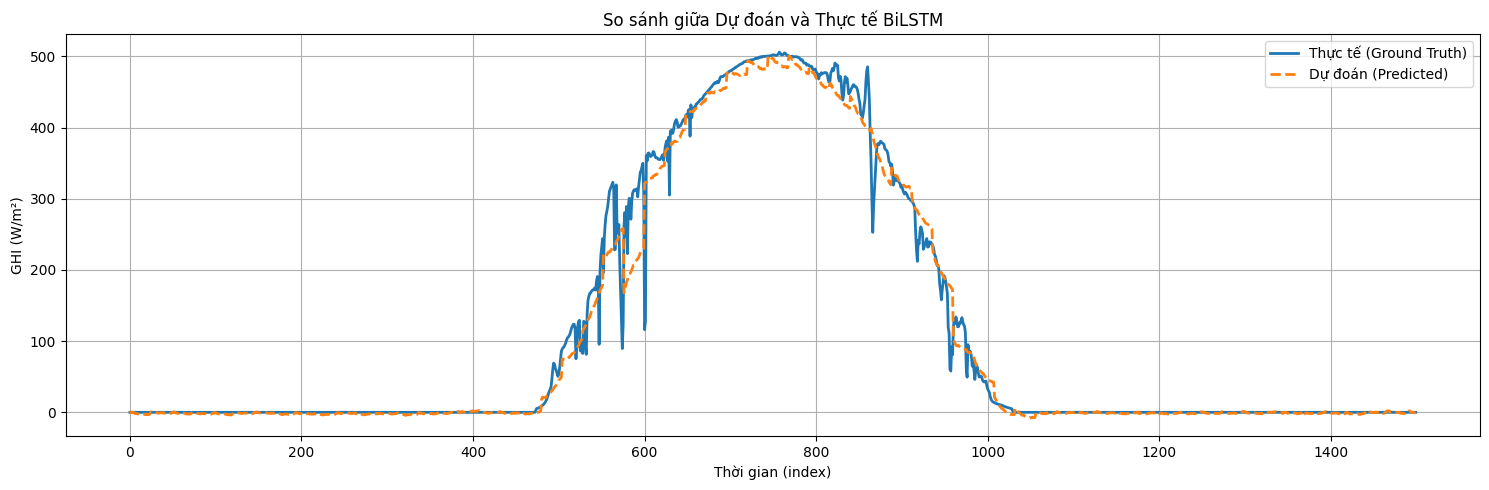

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(all_targets[:1500], label='Thực tế (Ground Truth)', linewidth=2)
plt.plot(all_scores[:1500], label='Dự đoán (Predicted)', linewidth=2, linestyle='--')

plt.title('So sánh giữa Dự đoán và Thực tế BiLSTM')
plt.xlabel('Thời gian (index)')
plt.ylabel('GHI (W/m²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
import torch.nn as nn

class BiLSTM_(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length):
        super(BiLSTM_, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=0.2, bidirectional=True)
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Linear(seq_length * hidden_size * 2, seq_length)

    def forward(self, x):
        out, _ = self.lstm(x)                         # out shape: (batch_size, seq_length, hidden_size*2)
        out = self.dropout(out)
        out = out.reshape(out.size(0), -1)            # flatten: (batch_size, seq_len * hidden_size * 2)
        out = self.fc(out)                            # (batch_size, seq_length)
        return out

In [41]:
from torchinfo import summary

model_print = BiLSTM_(
    input_size=8,
    hidden_size=64,
    num_layers=2,
    seq_length=24
).to(device)

summary(model_print, input_size=(16, 24, 8))

Layer (type:depth-idx)                   Output Shape              Param #
BiLSTM_                                  [16, 24]                  --
├─LSTM: 1-1                              [16, 24, 128]             137,216
├─Dropout: 1-2                           [16, 24, 128]             --
├─Linear: 1-3                            [16, 24]                  73,752
Total params: 210,968
Trainable params: 210,968
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 53.87
Input size (MB): 0.01
Forward/backward pass size (MB): 0.40
Params size (MB): 0.84
Estimated Total Size (MB): 1.25

In [42]:
pip install rich

Note: you may need to restart the kernel to use updated packages.


In [43]:
from rich import print
from torchinfo import summary

model = BRNN_Printable(input_size=8, hidden_size=64, num_layers=2, seq_length=24).to("cuda")
info = summary(model, input_size=(16, 24, 8), verbose=0)

print(f"[bold magenta]{info}[/bold magenta]")

==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
BRNN_Printable                           [16, 24]                  --
├─LSTM: 1-1                              [16, 24, 128]             137,216
├─Dropout: 1-2                           [16, 24, 128]             --
├─Linear: 1-3                            [16, 24]                  73,752
==========================================================================================
Total params: 210,968
Trainable params: 210,968
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 53.87
==========================================================================================
Input size (MB): 0.01
Forward/backward pass size (MB): 0.40
Params size (MB): 0.84
Estimated Total Size (MB): 1.25
==========================================================================================